# Assignment 3
In this assignment the task is to use the VGG16 model to extract features from the CIFAR-10 dataset and then train a new model on these features. The goal is to achieve a higher accuracy than 63%.

Load the CIFAR-10 dataset from the directory `../../CIFAR-10-images/` and split it into training, validation, and test sets.

In [15]:
import keras

batch_size = 32
img_size = (32, 32)

train_dataset, validation_dataset = keras.utils.image_dataset_from_directory(
    '../Datasets/CIFAR-10-images/train',
    batch_size=batch_size,
    image_size=img_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='both',
    seed=123)

test_dataset = keras.utils.image_dataset_from_directory(
    '../Datasets/CIFAR-10-images/test',
    batch_size=batch_size,
    image_size=img_size,
    label_mode='categorical')

Found 50000 files belonging to 10 classes.
Using 40000 files for training.
Using 10000 files for validation.
Found 10000 files belonging to 10 classes.


## Feature extraction with VGG16-model
Instantiate the VGG16 model and load the weights from ImageNet. The input shape should be `(32, 32, 3)` and the top layer should not be included.

In [16]:
conv_base = keras.applications.vgg16.VGG16(
 weights="imagenet",
 include_top=False,
 input_shape=(32, 32, 3))

conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

## Feature extraction
Extract features and labels from the training, validation, and test datasets. The function preprocesses the images using the VGG16 preprocessing function and then uses the VGG16 model to predict the features. The features are then concatenated into a single array for each dataset.

The extraction is done for train, validation, and test datasets.

In [17]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images, verbose=0)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

2025-04-04 15:03:52.133513: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Model definition
Define a new model with the dense layers consisting of 4 layers with 258, 128, 64, and 32 neurons respectively. Use ReLU activation and batch normalization and 0.2 dropout after each layer. The output layer should have 10 neurons with softmax activation as there are 10 classes.

In [50]:
from keras import layers

inputs = layers.Input(shape=(1, 1, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(258, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.models.Model(inputs=inputs, outputs=outputs)

## Model compilation
Compile the model and fit it to the training data. Use early stopping and save the best model.

In [51]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss="categorical_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss"),
        EarlyStopping(monitor="val_loss", patience=25, verbose=0),
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks, verbose=0)

## Testing the model
When testing the model on the test set, it achieves accuracy of 67.8% and a losss of 0.98. This is higher than the 63% goal.

In [52]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6850 - loss: 0.9641
Test Accuracy: 0.6782000064849854
Test Loss: 0.9856209754943848


## Plotting the results
Plot the training and validation accuracy and loss.

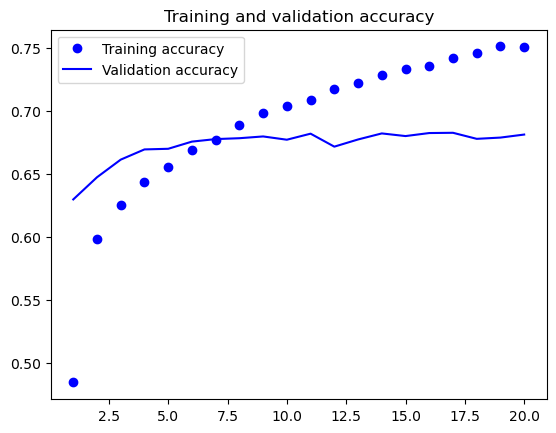

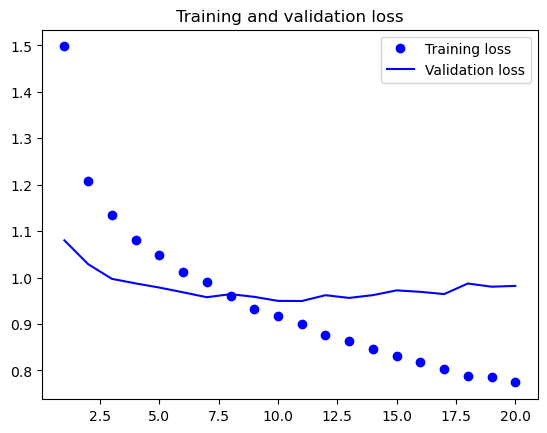

In [53]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

## Conclusion
The best accuracy is achieved with steady batch normalization and dropout. Tried the model with adam optimizer, but rmsprop was better.